# Assignment 5 : Deep learning
<br>Last updated on 11/02/2023</br>


credit : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


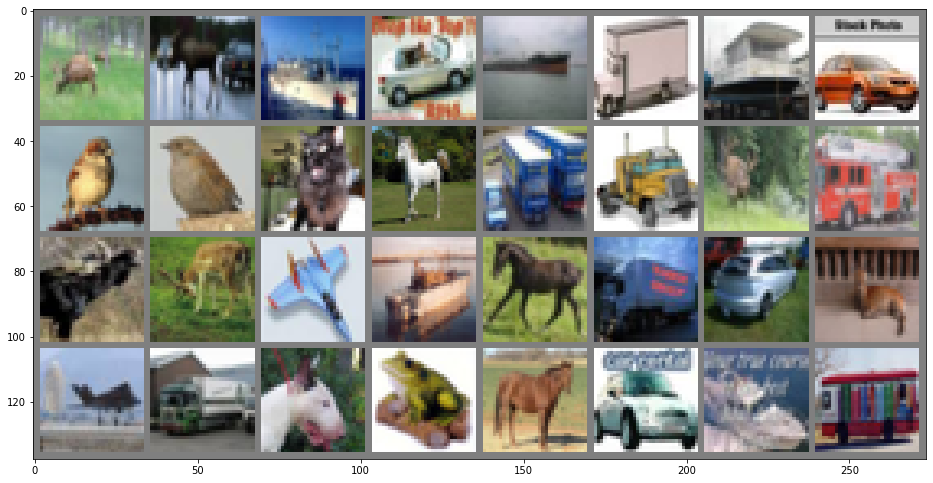

deer  deer  ship  car   ship  truck ship  car   bird  bird  cat   horse truck truck deer  truck deer  deer  plane ship  horse truck car   deer  plane truck dog   frog  horse car   ship  truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model1: NN

Create a model to have an image of 32*32 pixels as an input with 10 output classes.

The model composes of flatten, dropout 20%, dense with 128 neurons, and output layer (with softmax) to classify each image into 10 classes.
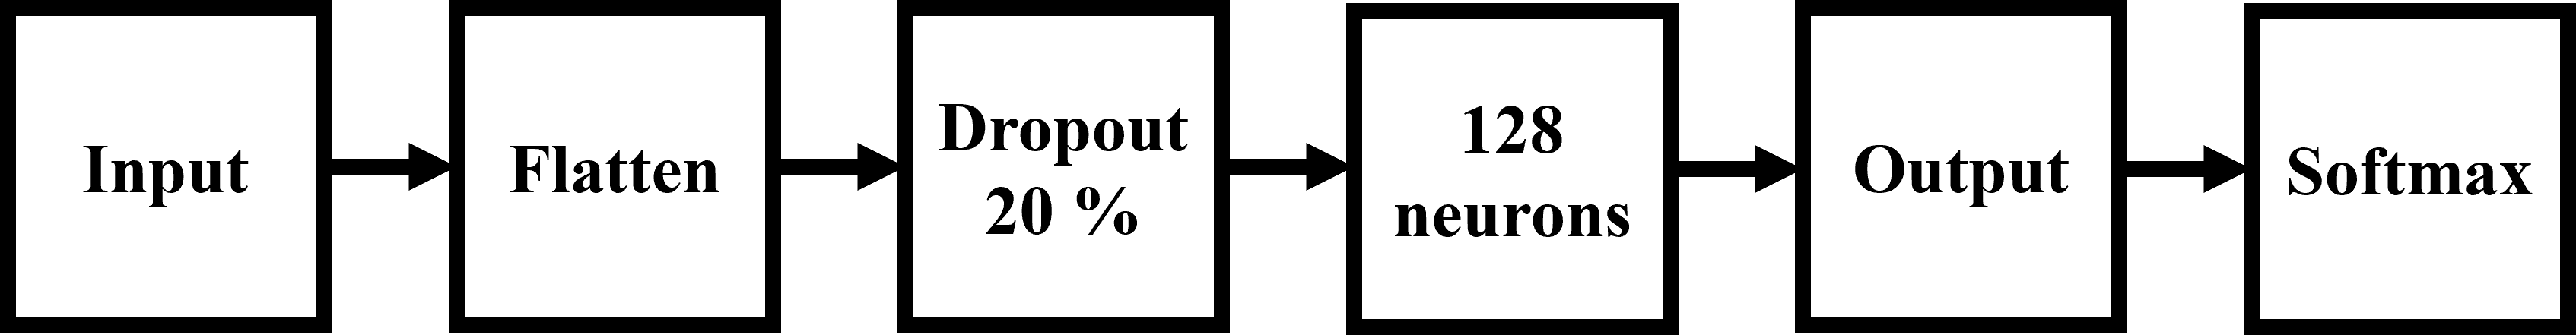

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout= nn.Dropout(p=0.2);
        self.dense = nn.Linear(3072,128)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(128,10)
        self.softmax = nn.Softmax(dim=1)
        '''
        Insert your code here

        '''

    def forward(self, x):
        x=self.flatten(x)
        x=self.dropout(x);
        x=self.dense(x);
        x=self.relu(x)
        x=self.dense2(x)
        x=self.softmax(x);
        return x;
        '''
        Insert your code here

        '''


net = Net().to(device)

Optimizer and criterion

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Training Model

In [8]:
PATH = './cifar_net.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_val_loss = 0.0
    y_predict = list()
    y_labels = list()
    training_loss = 0.0
    n = 0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs) # forward
        loss = criterion(outputs, labels) # calculate loss from forward pass
        loss.backward() # just calculate
        optimizer.step() # update weights here

        # aggregate statistics
        training_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        '''
        Insert your code here

        '''
    avg_loss = running_loss/len(trainloader)
    net.eval()
    y_predict = list()
    y_labels = list()
    validation_loss = 0.0
    with torch.no_grad():
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs=net(inputs);
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            '''
            Insert your code here

            '''

        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

print('Finished Training')
torch.save(net.state_dict(), PATH)

Best model was saved at Epoch 0
Finished Training


In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Evaluation 

In [10]:
predict = list()
label = list()
test_loss = 0.0
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        label += list(labels.cpu().numpy())
        predict += list(outputs.argmax(dim=1).cpu().numpy())
        '''
        Insert your code here

        '''

print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)

Classification report
              precision    recall  f1-score   support

           0     0.4933    0.5900    0.5373      1000
           1     0.6046    0.4250    0.4991      1000
           2     0.3941    0.1880    0.2546      1000
           3     0.3104    0.3200    0.3151      1000
           4     0.4446    0.3330    0.3808      1000
           5     0.4377    0.3020    0.3574      1000
           6     0.3975    0.7060    0.5086      1000
           7     0.5474    0.5140    0.5302      1000
           8     0.5366    0.6670    0.5947      1000
           9     0.4824    0.5770    0.5255      1000

    accuracy                         0.4622     10000
   macro avg     0.4649    0.4622    0.4503     10000
weighted avg     0.4649    0.4622    0.4503     10000



# Model2: CNN

Modify Model1:

Before the flatten layer, add 2 layers of Conv2D with kernel(2*2) for 32 and 64 filters with relu activation, respectively.
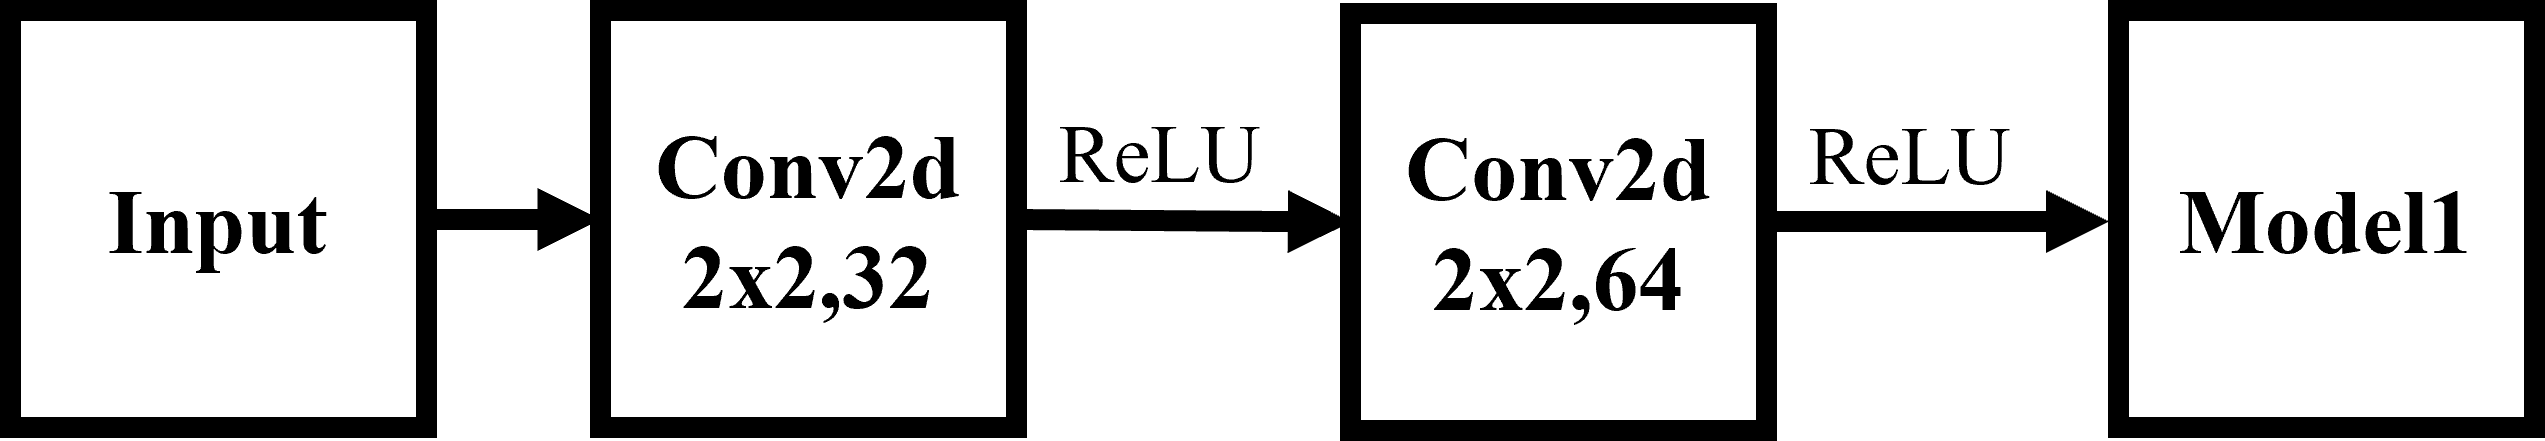

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,32,2);
        self.relu= nn.ReLU()
        self.conv2= nn.Conv2d(32,64,2)
        self.flatten = nn.Flatten()
        self.dropout= nn.Dropout(p=0.2);
        self.dense = nn.Linear(57600,128)
        self.dense2 = nn.Linear(128,10)
        self.softmax = nn.Softmax(dim=1)
        '''
        Insert your code here

        '''

    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.flatten(x)
        x=self.dropout(x);
        x=self.dense(x);
        x=self.relu(x)
        x=self.dense2(x)
        x=self.softmax(x);
        return x
        '''
        Insert your code here

        '''


net = CNN1().to(device)

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [13]:
PATH = './cifar_CNN1.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_val_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs=net(inputs)
        loss = criterion(outputs,labels)
        validation_loss += loss.item()
        loss.backward()
        optimizer.step()
        '''
        Insert your code here

        '''
    avg_loss = running_loss/len(trainloader)
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs=net(inputs);
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            '''
            Insert your code here

            '''

        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

print('Finished Training')
torch.save(net.state_dict(), PATH)

Best model was saved at Epoch 0
Finished Training


In [14]:
net = CNN1()
net.load_state_dict(torch.load(PATH))
net.to(device)

CNN1(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=57600, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [15]:
predict = list()
label = list()
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        label += list(labels.cpu().numpy())
        predict += list(outputs.argmax(dim=1).cpu().numpy())
        '''
        Insert your code here

        '''

print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)

Classification report
              precision    recall  f1-score   support

           0     0.6481    0.7220    0.6831      1000
           1     0.8014    0.6740    0.7322      1000
           2     0.5168    0.4910    0.5036      1000
           3     0.4439    0.4830    0.4626      1000
           4     0.5534    0.5600    0.5567      1000
           5     0.5432    0.5340    0.5386      1000
           6     0.7236    0.7070    0.7152      1000
           7     0.7005    0.6830    0.6916      1000
           8     0.7579    0.7200    0.7385      1000
           9     0.6820    0.7570    0.7175      1000

    accuracy                         0.6331     10000
   macro avg     0.6371    0.6331    0.6340     10000
weighted avg     0.6371    0.6331    0.6340     10000



# Model3: CNN with max-pool & dropout

Modify Model2:

After Conv2D layers in Model2, add MaxPooling2D with pooling size (2*2) and then dropout 30%.
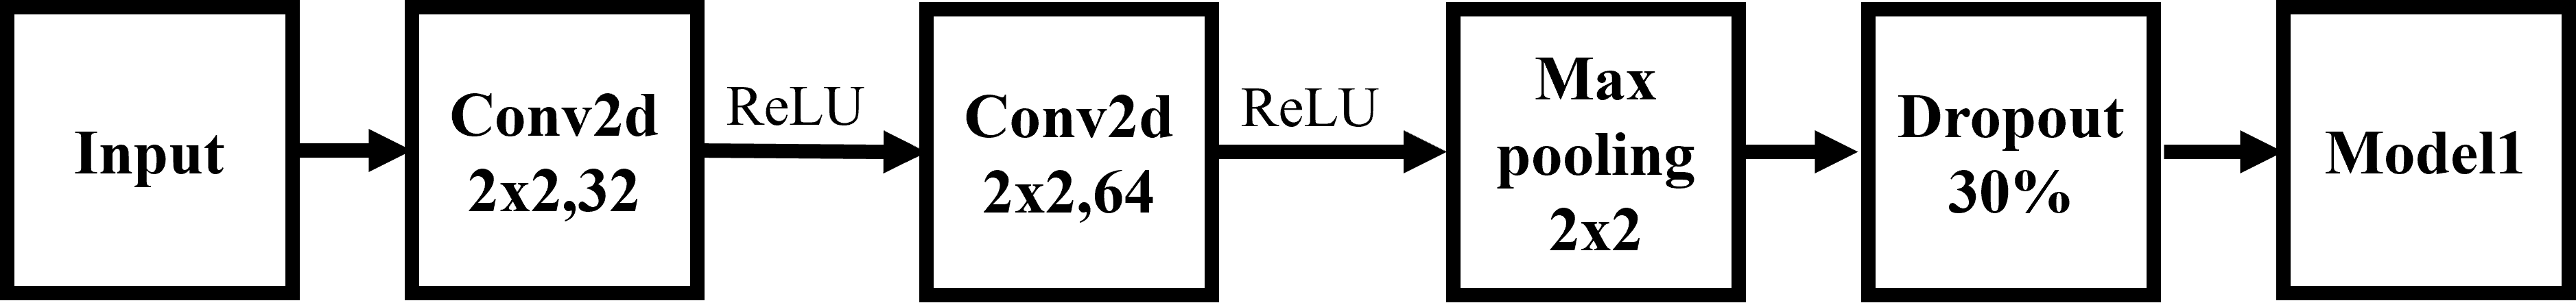

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,32,2);
        self.relu= nn.ReLU()
        self.conv2= nn.Conv2d(32,64,2)
        self.maxpool= nn.MaxPool2d(2)
        self.dropout1=nn.Dropout(p=0.3)
        self.flatten = nn.Flatten()
        self.dropout2= nn.Dropout(p=0.2);
        self.dense = nn.Linear(14400,128)
        self.dense2 = nn.Linear(128,10)
        self.softmax = nn.Softmax(dim=1)
        '''
        Insert your code here

        '''

    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.dropout1(x)
        x=self.flatten(x)
        x=self.dropout2(x);
        x=self.dense(x);
        x=self.relu(x)
        x=self.dense2(x)
        x=self.softmax(x);
        return x

        '''
        Insert your code here

        '''


net = CNN2().to(device)

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [18]:
PATH = './cifar_CNN2.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_val_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs=net(inputs)
        loss = criterion(outputs,labels)
        validation_loss += loss.item()
        loss.backward()
        optimizer.step()
        '''
        Insert your code here

        '''
    avg_loss = running_loss/len(trainloader)
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs=net(inputs);
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            y_labels += list(labels.cpu().numpy())
            y_predict += list(outputs.argmax(dim=1).cpu().numpy())
            '''
            Insert your code here

            '''

        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

print('Finished Training')
torch.save(net.state_dict(), PATH)

Best model was saved at Epoch 0
Finished Training


In [19]:
net = CNN2()
net.load_state_dict(torch.load(PATH))
net.to(device)

CNN2(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=14400, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [20]:
predict = list()
label = list()
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        label += list(labels.cpu().numpy())
        predict += list(outputs.argmax(dim=1).cpu().numpy())
        '''
        Insert your code here

        '''

print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)

Classification report
              precision    recall  f1-score   support

           0     0.6972    0.6770    0.6870      1000
           1     0.7829    0.7610    0.7718      1000
           2     0.5248    0.5510    0.5376      1000
           3     0.4517    0.5520    0.4968      1000
           4     0.6226    0.5460    0.5818      1000
           5     0.5589    0.5840    0.5711      1000
           6     0.8103    0.6750    0.7365      1000
           7     0.6811    0.7410    0.7098      1000
           8     0.7281    0.8060    0.7651      1000
           9     0.8072    0.6740    0.7346      1000

    accuracy                         0.6567     10000
   macro avg     0.6665    0.6567    0.6592     10000
weighted avg     0.6665    0.6567    0.6592     10000

